# E3. 카메라 스티커앱 만들기 첫걸음

- 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술.

- 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 만들기.

### [ 목 표 ]

   1. 얼굴인식 카메라의 흐름을 이해
   2. dlib 라이브러리 사용
   3. 이미지 배열의 인덱싱 예외 처리
   
### [ 개 요 ]

얼굴 사진 => (얼굴의 bounding box 찾기) => 얼굴영역의 landmark 검출 => 스티커 삽입

# Step_0. 스티커 이미지 및 사진 준비

### [ 고양이 수염 스티커 ]
> wget www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1
> mv cat-whiskers.png ~/practice/camera_sticker/camera_sticker/images

### [ Opencv-python ]
:컴퓨터 비전, 머신러닝과 관련된 다양한 알고리즘 지원, 파이썬 -> C언어로 구현하여 느린점을 보완, numpy를 이용하여 이미지프로세싱 등에 필요한 행렬연산을 손쉽게 함 
> pip install opencv-python

### [ cmake ]
: 소스코드-결과물 사이를 깔끔하게 추상화 
> pip install cmake       

### [ Dlib ]
: dlib을 활용해 face detector 선언 => 얼굴의 bounding box만들기 
> pip install dlib

### [ landmark localization ]
: Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 사용 - 학습 알고리즘은 regression tree의 앙상블 모델을 사용
> - wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 
> - mv shape_predictor_68_face_landmarks.dat.bz2 ~/portpolio_mj/camera_sticker/models 
> - cd ~/portpolio_mj/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

# Step_1. 필요한 패키지 import 및 사전작업

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

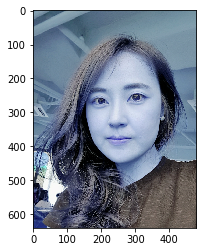

In [2]:
# 스티커 붙일 내 사진 불러와서 사이즈 재조정
mypicture_path = os.getenv('HOME')+'/portfolio_mj/camera_sticker/images/mypicture.jpg'
img_bgr = cv2.imread(mypicture_path)
img_bgr = cv2.resize(img_bgr, (480, 640))
img_show = img_bgr.copy()                    # 출력용 이미지를 별도 보관

plt.imshow(img_show)
plt.show()

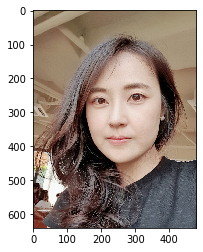

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # bgr => rgb 로 변경
plt.imshow(img_rgb)
plt.show()

img_show_rgb = img_rgb.copy()

# Step_2. 얼굴 검출 face detection - bounding box

In [4]:
# bonunding box 찾기 (dlib의 get_frontal_face_detector()을 이용)

import dlib

# dlib의 얼굴찾는 함수 face_detector로 설정
face_detector = dlib.get_frontal_face_detector()

# bounding box의 위치 리스트
face_rect_pos = face_detector(img_rgb, 2)  # (image, num of img pyramid)
print(face_rect_pos)

rectangles[[(147, 199) (378, 430)]]


In [5]:
print("{}개의 얼굴을 찾았습니다.".format(len(face_rect_pos)))

1개의 얼굴을 찾았습니다.


left: 147
right: 378
top: 199
bottom: 430
[(147, 199) (378, 430)]


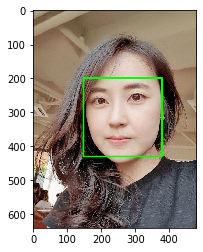

In [6]:
# bounding box 그리기

for dlib_rect in face_rect_pos:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print("left:",l)
    print("right:",r)
    print("top:",t)
    print("bottom:",b)

    cv2.rectangle(img_show_rgb, (l,t), (r,b), (0,255,0), 3, lineType=cv2.LINE_AA)
    # (l,t): 사각형 왼쪽 위 시작 / (r, b): 사각형 오른쪽 아래 끝 
    # (0,255,0): 녹색선 / 3: 선굵기

print(face_rect_pos[0])
    
plt.imshow(img_show_rgb)
plt.show()

# Step_3. 얼굴 랜드마크 face landmark

In [7]:
# 얼굴에 점 찍어줄 dlib의 model 불러오기
model_path = os.getenv('HOME')+'/portfolio_mj/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)    # 얼굴 위치에서 랜드마크 찾기

In [8]:
list_landmarks = []

for dlib_rect in face_rect_pos :
    points = landmark_predictor(img_show_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) 
    #lambda뒤의 p는 변수 /  (p.x, p.y)는 함수 / points.parts()는 함수에 넣어줄 데이터
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 68개의 face landmark점이 있음

68


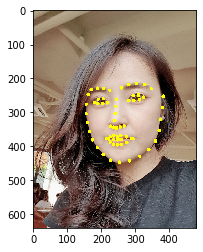

In [9]:
# 68개의 landmark dot을 넣어놓은 list_landmarks를 가져와서 img_show사진에 찍음
for landmark in list_landmarks :
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (0,255,255),-1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # img_show는 bgr이므로 변환
plt.imshow(img_show_rgb)

# Step_4. 스티커 적용하기

In [10]:
for dlib_rect, landmark in zip(face_rect_pos, list_landmarks): 
    print(landmark[2], landmark[30], landmark[36], landmark[48])
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2
    h = landmark[48][1] - landmark[36][1]
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(159, 330) (239, 324) (179, 270) (214, 378)
(x,y) : (159,270)
(w,h) : (160,108)


In [11]:
list(zip(face_rect_pos, list_landmarks))

[(rectangle(147,199,378,430),
  [(155, 276),
   (155, 304),
   (159, 330),
   (165, 356),
   (174, 381),
   (187, 404),
   (205, 424),
   (226, 440),
   (253, 446),
   (282, 442),
   (312, 429),
   (338, 409),
   (358, 384),
   (369, 353),
   (373, 321),
   (378, 287),
   (381, 253),
   (161, 248),
   (170, 233),
   (188, 229),
   (206, 230),
   (224, 235),
   (259, 228),
   (280, 218),
   (303, 214),
   (327, 218),
   (345, 231),
   (243, 261),
   (242, 282),
   (240, 303),
   (239, 324),
   (226, 341),
   (235, 344),
   (244, 346),
   (255, 343),
   (266, 340),
   (179, 270),
   (190, 261),
   (205, 260),
   (218, 272),
   (204, 274),
   (189, 274),
   (280, 265),
   (293, 251),
   (308, 249),
   (323, 256),
   (311, 263),
   (295, 265),
   (214, 378),
   (225, 372),
   (236, 368),
   (246, 372),
   (256, 368),
   (273, 372),
   (293, 378),
   (274, 388),
   (258, 394),
   (247, 395),
   (235, 393),
   (225, 387),
   (220, 378),
   (236, 379),
   (247, 381),
   (257, 380),
   (287, 3

(cf) **`zip(*iterable)`** 은 동일한 개수로 이루어진 자료형을 묶어 주는 역할을 하는 함수

> list(zip([1, 2, 3], [4, 5, 6]))
>> [(1, 4), (2, 5), (3, 6)]

108


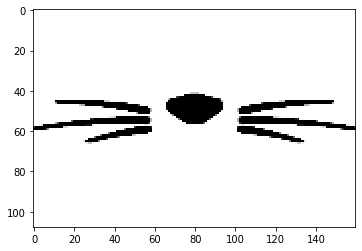

In [12]:
# 고양이 수염 스티커 불러오기
sticker_path = os.getenv('HOME')+'/portfolio_mj/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h)) # 사진의 얼굴크기에 맞게 스티커 크기 조정

print(img_sticker.shape[0])
plt.imshow(img_sticker)

In [13]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치
sticker_area = img_rgb[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

img_rgb[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] \
= np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)


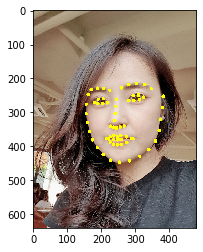

In [14]:
plt.imshow(img_show_rgb)

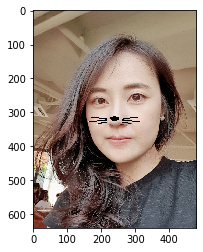

In [15]:
plt.imshow(img_rgb)

# Step 5. 문제점 찾아보기

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

=> 위 문제점을 해결해 보고자 회전시킨 사진에 dlib.get_frontal_face_detector()을 해 보았으나 실패하였습니다. 이것은 아마도 dlib.get_frontal_face_detector()는 사진을 증명사진 처럼 얼굴 각도일 때 찾을 수 있기 때문이지 않을까 생각하게 되었습니다. 그래서 사진을 먼저 회전시켜주어 dlib.get_frontal_face_detector()를 사용한 후 다시 원래대로 복구 시켜야 하는데 여기서 문제는 그 각도를 어떻게 찾아주어야 하는 문제가 남았습니다. 몇가지 참고할만한 것들을 찾았으나 끝내 실패 했습니다 ㅠㅠ

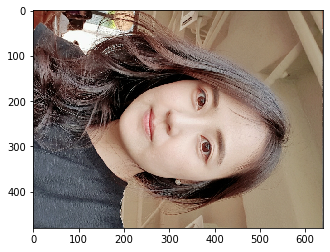

In [29]:
# 스티커 붙일 내 사진 불러와서 사이즈 재조정
mypicture_path = os.getenv('HOME')+'/portfolio_mj/camera_sticker/images/lay_down.jpeg'
img_bgr1 = cv2.imread(mypicture_path)
img_bgr1 = cv2.resize(img_bgr1, (640, 480))
img_rgb1 = cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB)  # bgr => rgb 로 변경
img_show1 = img_rgb1.copy()                    # 출력용 이미지를 별도 보관

plt.imshow(img_show1)
plt.show()

rectangles[]


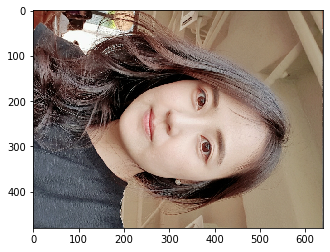

In [32]:
# bonunding box 찾기 (dlib의 get_frontal_face_detector()을 이용)

import dlib

# dlib의 얼굴찾는 함수 face_detector로 설정
face_detector = dlib.get_frontal_face_detector()

# bounding box의 위치 리스트
face_rect_pos = face_detector(img_rgb1, 2)  # (image, num of img pyramid)
print(face_rect_pos)

# bounding box 그리기

for dlib_rect in face_rect_pos:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print("left:",l)
    print("right:",r)
    print("top:",t)
    print("bottom:",b)

    cv2.rectangle(img_show1, (l,t), (r,b), (0,255,0), 3, lineType=cv2.LINE_AA)
    # (l,t): 사각형 왼쪽 위 시작 / (r, b): 사각형 오른쪽 아래 끝 
    # (0,255,0): 녹색선 / 3: 선굵기
    
plt.imshow(img_show1)
plt.show()


In [ ]:
# 다른 사람 코드 참조
np.where(img_sticker!=whisker_c ,sticker_area,img_sticker).astype(np.uint8)
img_sticker의 수염과 코부분을 다른 색으로 바꾸고 바꾼색이 아닐경우 배경색을 이용


img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)


## [ 회 고 ]

1. 이번 프로젝트에서 어려웠던 점: dlib이용하여 얼굴찾기를 하는데 박스가 잘 그려지지 않았음

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.

    - 알아낸 점: bounding box가 변수 잘못쓴게 아니라 시스템 문제인줄 알고 찾아보다가 num of img pyramid의 1은 업샘플링을 한번 하겠다는 의미라는 말을 다시 인식했고 이를 늘리면 더 잘 인식할 수 있음을 알게됨. (num of img pyramid의 1에서 2로 늘렸더니 bounding box가 좀 더 fit하게 나옴을 발견.)
    - 모호한 점: 사진이 회전했을 때 회전각도를 어떻게 찾아야 하는지... 다른 분들은 스티커 색을 조정해야 한다는데 왜 그래야 하는지... 시간에 쫒겨 물어보지 못했습니다 ㅠㅠ(그런데 제가 심지어 어떻게 물어봐야 하는지 감도 못잡았다는게 더 문제네요 ㅠㅠ)

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들.

- dlib이용하여 얼굴찾기를 하는데 박스가 잘 그려지지 않아서 num of img pyramid 1에서 2과 0으로 각각 조정 => 변수명의 오류였으므로 개선사항 없음, 대신 추후에 수를 늘려서 적용해본 결과 bounding box가 좀 더 fit하게 나옴을 발견.

- 자기만의 카메라앱 기능 구현을 완수하였다./ 원본에 스티커 사진이 정상적으로 합성되었다.

- 스티커 이미지를 정확한 원본 위치에 반영하였다. / 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

- 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다. / 	얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.
        

* 회전 사진 참고 문헌

https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/